In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp

# Empirical distribution as a sequence of numbers (samples)
def empirical_distribution(samples):
    n = len(samples)
    return lambda x: jnp.sum(samples <= x) / n

# Stieltjes Transform
def stieltjes_transform(samples, z):
    return jnp.mean(1 / (z - samples))

# Moment Generating Function
def moment_generating_function(samples, t):
    return jnp.mean(jnp.exp(t * samples))

# Cumulant Generating Function (Log of Moment Generating Function)
def cumulant_generating_function(samples, t):
    return jnp.log(moment_generating_function(samples, t))

# R-transform (First derivative of Cumulant Generating Function)
def r_transform(samples, z):
    return grad(cumulant_generating_function)(samples, z)

# S-transform
def s_transform(samples, z):
    G_inv = lambda u: jnp.mean(samples / (1 + u * samples))  # G(z) is the Stieltjes transform
    return (z + 1) / z * G_inv(z)

# Function to generate the transforms for given samples
def generate_transforms(samples):
    transforms = {
        'stieltjes': lambda z: stieltjes_transform(samples, z),
        'moment': lambda t: moment_generating_function(samples, t),
        'cumulant': lambda t: cumulant_generating_function(samples, t),
        'r': lambda z: r_transform(samples, z),
        's': lambda z: s_transform(samples, z)
    }
    return transforms

# Example usage
samples = jnp.array([1.0, 2.0, 3.0, 4.0, 5.0])  # Example empirical distribution
transforms = generate_transforms(samples)

# Accessing transforms
z = 1.5  # Example complex number for Stieltjes, R, and S transforms
t = 0.5  # Example real number for Moment and Cumulant generating functions

print("Stieltjes Transform at z:", transforms['stieltjes'](z))
print("Moment Generating Function at t:", transforms['moment'](t))
print("Cumulant Generating Function at t:", transforms['cumulant'](t))
print("R-transform at z:", transforms['r'](z))
print("S-transform at z:", transforms['s'](z))


Stieltjes Transform at z: -0.2704762
Moment Generating Function at t: 5.6840487
Cumulant Generating Function at t: 1.7376637
R-transform at z: [0.0028901  0.01295253 0.05804921 0.2601585  1.1659496 ]
S-transform at z: 0.8683728


In [3]:
import sympy as sp

def NC(n):
    if n==1:
        return [[[0,]]]
    parts = NC(n-1)
    return [p+[[n-1,]] for p in parts] +[p[:len(p)-1]+[p[-1]+[n-1]] for p in parts]

def non_crossing_partitions(n):
    return NC(n)

def make_partitions(elements):
    yield from _make_partitions(sorted(elements, reverse=True), [], []) 

def _make_partitions(elements, active_partitions, inactive_partitions):
    if not elements:
        yield active_partitions + inactive_partitions
        return

    elem = elements.pop()

    # Make create a new partition
    active_partitions.append([elem])
    yield from _make_partitions(elements, active_partitions, inactive_partitions)
    active_partitions.pop()

    # Add element to each existing partition in turn
    size = len(active_partitions)
    for part in active_partitions[::-1]:
        part.append(elem)
        yield from _make_partitions(elements, active_partitions, inactive_partitions)
        part.pop()

        # Remove partition that would create a cross if new elements were added
        inactive_partitions.append(active_partitions.pop())
    
    # Add back removed partitions
    for _ in range(size):
        active_partitions.append(inactive_partitions.pop())

    elements.append(elem)

def moebius_function(pi, n):
    """Calculate the Möbius function μ(pi, 1_n) for a partition pi of {1, ..., n}."""
    k = len(pi)
    mu_value = (-1)**(k - 1)
    for block in pi:
        mu_value *= sp.factorial(len(block) - 1)
    return mu_value

def moments_to_cumulants(moments):
    """Convert moments to cumulants using the inverse of the moment-cumulant formula."""
    n = len(moments)
    cumulants = [0] * n
    for i in range(n):
        m = i + 1
        partitions = non_crossing_partitions(m)
        cumulants[i] = sum(moebius_function(pi, m) * sp.prod(moments[len(b) - 1] for b in pi) for pi in partitions)
    return cumulants

def cumulants_to_moments(cumulants):
    """Convert cumulants to moments using the moment-cumulant formula."""
    n = len(cumulants)
    moments = [0] * n
    for i in range(n):
        m = i + 1
        partitions = non_crossing_partitions(m)
        moments[i] = sum(sp.prod(cumulants[len(b) - 1] for b in pi) for pi in partitions)
    return moments

# Example usage
moments = [1, 2, 5, 14]  # Example moments for testing
cumulants = moments_to_cumulants(moments)
reconstructed_moments = cumulants_to_moments(cumulants)

print("Given Moments:", moments)
print("Calculated Cumulants:", cumulants)
print("Reconstructed Moments from Cumulants:", reconstructed_moments)


Given Moments: [1, 2, 5, 14]
Calculated Cumulants: [1, 1, 7, 65]
Reconstructed Moments from Cumulants: [1, 2, 10, 84]


In [4]:
def NC(n):
    if n==0:
        return [[[]]]
    P = []
    for i in range(n):
        parts1 = NC(i)
        parts2 = NC(n-1-i)
        parts2 = [[[a+i+1 for a in partition] for partition in partitions] for partitions in parts2]
        for j in range(len(parts2)):
            parts2[j][0] = [i] + parts2[j][0]
        for P1 in parts1:
            for P2 in parts2:
                if P1[0]:
                    P.append(P1+P2)
                else:
                    P.append(P2)
    return P

(NC(3))

[[[0, 1, 2]], [[0, 1], [2]], [[0], [1, 2]], [[0, 1], [2]], [[0], [1], [2]]]

We have 
$$k_p = m_p + \sum_{j=2}^p \frac{(-1)^{j-1}}{j} \binom{p+j-2}{j-1} \sum_{Q_j} m_{q_1} \cdots m_{q_j}
$$
and 
$$
m_p = k_p + \sum_{j=2}^p \frac{1}{j} \binom{p}{j-1} \sum_{Q_j} k_{q_1} \cdots k_{q_j}
$$
where 
$$
Q_j = \left\{ (q_1, q_2, \ldots, q_j) \in \mathbb{N}^j \mid \sum_{i=1}^j q_i = p \right\}.

$$

In [5]:
from functools import lru_cache
import math 
import numpy as np

@lru_cache(maxsize=None) 
def int_parts(n, j):
    if j==1:
        return [[n]]
    L = []
    for q in range(1,n):
        L += [[q]+p for p in int_parts(n-q, j-1)]
    return L 

def unique_parts(parts):
    parts = [sorted(p) for p in parts]
    P = [parts[0]]
    C = [1]
    for i in range(1, len(parts)):
        if parts[i]==parts[i-1]:
            C[-1] += 1
        else:
            P.append(parts[i])
            C.append(1)
    return P, C

def commulant(p, moments):
    S = 0
    f = f'commulant {p} = \n'
    for j in range(1, p+1):
        parts = int_parts(p, j)
        parts, parts_counts = unique_parts(parts)
        # print(parts)
        for P, C in zip(parts, parts_counts):
            c = math.comb(p+j-2, j-1) * (-1)**(j-1) 
            ms,cs = np.unique(P,return_counts=True)
            S += C * c / j * math.prod([moments[m]**c for m,c in zip(ms,cs)])
            s = ' '.join(f'm_{m}ˆ{c}' for m,c in zip(ms, cs))
            coef = C * c//j
            f += (f' {"+" if coef > 0 else "-"}{"" if abs(coef)==1 else abs(coef)} {s}')
    print(f)
    return S

commulant(2, moments=[0,1,2,3,4,5,6])
commulant(3, moments=[0,1,2,3,4,5,6])
commulant(4, moments=[0,1,2,3,4,5,6])


commulant 2 = 
 + m_2ˆ1 - m_1ˆ2
commulant 3 = 
 + m_3ˆ1 -3 m_1ˆ1 m_2ˆ1 +2 m_1ˆ3
commulant 4 = 
 + m_4ˆ1 -2 m_1ˆ1 m_3ˆ1 -2 m_2ˆ2 -2 m_1ˆ1 m_3ˆ1 +10 m_1ˆ2 m_2ˆ1 -5 m_1ˆ4


-1.0

In [6]:
def free_moments(A, order = 10):
    svals = np.linalg.svd(A).S
    return [np.mean(svals**m) for m in range(order)]

def free_commulants(A, order = 10):
    moments = free_moments(A, order = order)
    comms = []
    for p in range(order):
        k = commulant(p, moments=moments)
        comms.append(k)
    comms[0] = 1
    for ki,k in enumerate(comms):
        print(f'k_{ki} = {k:.4f}')
    return comms
    
n, d = 1000, 1000
A = np.random.randn(n, d) / np.sqrt(d)
A = A @ A.T
B = np.random.randn(n, d) / np.sqrt(d)
B = B @ B.T
C = A @ B.T 

order = 6
A_coms = free_commulants(A, order=order)
B_coms = free_commulants(B, order=order)
C_coms = free_commulants(C, order=order)

np.mean(np.diag(A @ A.T))


commulant 0 = 

commulant 1 = 
 + m_1ˆ1
commulant 2 = 
 + m_2ˆ1 - m_1ˆ2
commulant 3 = 
 + m_3ˆ1 -3 m_1ˆ1 m_2ˆ1 +2 m_1ˆ3
commulant 4 = 
 + m_4ˆ1 -2 m_1ˆ1 m_3ˆ1 -2 m_2ˆ2 -2 m_1ˆ1 m_3ˆ1 +10 m_1ˆ2 m_2ˆ1 -5 m_1ˆ4
commulant 5 = 
 + m_5ˆ1 -3 m_1ˆ1 m_4ˆ1 -5 m_2ˆ1 m_3ˆ1 -3 m_1ˆ1 m_4ˆ1 +5 m_1ˆ2 m_3ˆ1 +5 m_1ˆ1 m_2ˆ2 +5 m_1ˆ2 m_3ˆ1 +10 m_1ˆ1 m_2ˆ2 +5 m_1ˆ2 m_3ˆ1 -35 m_1ˆ3 m_2ˆ1 +14 m_1ˆ5
k_0 = 1.0000
k_1 = 0.9992
k_2 = 0.9981
k_3 = 1.0009
k_4 = 1.0145
k_5 = 1.0473
commulant 0 = 

commulant 1 = 
 + m_1ˆ1
commulant 2 = 
 + m_2ˆ1 - m_1ˆ2
commulant 3 = 
 + m_3ˆ1 -3 m_1ˆ1 m_2ˆ1 +2 m_1ˆ3
commulant 4 = 
 + m_4ˆ1 -2 m_1ˆ1 m_3ˆ1 -2 m_2ˆ2 -2 m_1ˆ1 m_3ˆ1 +10 m_1ˆ2 m_2ˆ1 -5 m_1ˆ4
commulant 5 = 
 + m_5ˆ1 -3 m_1ˆ1 m_4ˆ1 -5 m_2ˆ1 m_3ˆ1 -3 m_1ˆ1 m_4ˆ1 +5 m_1ˆ2 m_3ˆ1 +5 m_1ˆ1 m_2ˆ2 +5 m_1ˆ2 m_3ˆ1 +10 m_1ˆ1 m_2ˆ2 +5 m_1ˆ2 m_3ˆ1 -35 m_1ˆ3 m_2ˆ1 +14 m_1ˆ5
k_0 = 1.0000
k_1 = 0.9986
k_2 = 0.9989
k_3 = 0.9989
k_4 = 1.0038
k_5 = 1.0245
commulant 0 = 

commulant 1 = 
 + m_1ˆ1
commulant 2 = 
 + m_2ˆ1 - m_1ˆ2
commulant 3 = 

1.9965710245778305

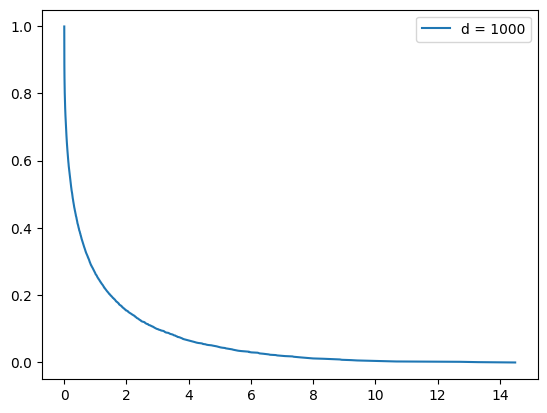

In [7]:
import matplotlib.pyplot as plt

df1, df2 = 1, 2
for d in [1000]:
    d0,d1,d2 = 1000,1000,d
    min_d = np.min([d0,d1,d2])
    A = np.random.randn(d0, d1)
    svd = np.linalg.svd(A, full_matrices=False)
    sings = np.random.chisquare(df=df1, size=len(svd.S)) / df1
    # sings = sings**(-1)
    # sings = sings / np.exp(np.mean(np.log(sings)))
    A = svd.U @ np.diag(sings) @ svd.Vh

    B = np.random.randn(d1, d2)
    svd = np.linalg.svd(B, full_matrices=False)
    sings = np.random.chisquare(df=df2, size=len(svd.S)) / df2
    # sings = sings / np.sqrt(d)
    # sings = sings / np.exp(np.mean(np.log(sings)))
    B = svd.U @ np.diag(sings) @ svd.Vh

    C = A @ B 
    sings = np.linalg.svd(C,).S[:min_d]
    sings = sings / np.mean(sings)
    # plt.figure()
    plt.plot((sings), np.arange(len(sings))/len(sings), label=f"d = {d}")
    # plt.hist(np.log(sings),30,density=True)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

Is it true that 
$$
E\log\det(U^\top D^{-2} U) \ge E -\log\det(U^\top D^2 U)
$$
or equivalently 
$$
E \log\det(U^\top D^{-2} U U^\top D^2 U) \ge 0
$$
we also have 
$$
\log\det(U^\top D^{-2} U)  \ge tr(U^\top D^{-2} U - I_n)
$$

/var/folders/lm/3y29pbg17l30756m1x_vpb040000gp/T/ipykernel_55363/2046066557.py:9: RuntimeWarning: divide by zero encountered in divide
  (1 / (2 * jnp.pi * gamma * x)) * jnp.sqrt((b - x) * (x - a)),


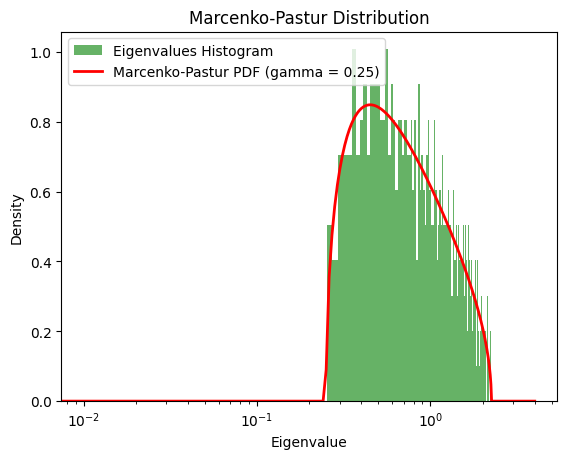

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def mp_pdf(x, gamma, sigma=1):
    a = sigma**2 * (1 - jnp.sqrt(gamma))**2
    b = sigma**2 * (1 + jnp.sqrt(gamma))**2
    pdf = jnp.where(
        (x >= a) & (x <= b),
        (1 / (2 * jnp.pi * gamma * x)) * jnp.sqrt((b - x) * (x - a)),
        0.0
    )
    return pdf

# Generate a random matrix
np.random.seed(0)  # For reproducibility
n = 2000  # Number of observations
p = 500   # Number of variables
gamma = p / n

# Generate an n x p matrix with i.i.d. standard normal entries
X = np.random.randn(n, p)

# Compute the sample covariance matrix
S = np.dot(X.T, X) / n

# Compute the eigenvalues of the sample covariance matrix
eigenvalues = np.linalg.eigvalsh(S)

# Compute the Marcenko-Pastur PDF
x = np.linspace(0, 4, 400)
pdf_values = mp_pdf(x, gamma)

# Plot the histogram of the eigenvalues and the Marcenko-Pastur PDF
plt.hist(eigenvalues, bins=100, density=True, alpha=0.6, color='g', label='Eigenvalues Histogram')
plt.plot(x, pdf_values, label=f'Marcenko-Pastur PDF (gamma = {gamma})', color='r', lw=2)
plt.xscale('log')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Marcenko-Pastur Distribution')
plt.legend()
plt.show()


In [424]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go


def mp_stieltjes_transform(z, gamma, sigma=1):
    term = (z - sigma**2 * (gamma + 1))**2 - 4 * gamma * sigma**4
    sqrt_term = jnp.sqrt(term)
    G_z = (sigma**2 * (1 - gamma) - z + sqrt_term) / (2 * gamma * sigma**2 * z)
    return G_z

def mp_s_transform(z, gamma, sigma=1):
    S_z = 1 / (sigma**2 * (1 + gamma * z))
    return S_z

def mp_r_transform(z, gamma, sigma=1):
    R_z = sigma**2 / (1 - sigma**2 * gamma * z)
    return R_z


def plot_complex_map(f, re_range=(-1,1), im_range=(-1,1), steps=100,):
    # Define the range for real and imaginary parts of z
    real_values = np.linspace(re_range[0], re_range[1], steps)
    imag_values = np.linspace(im_range[0], im_range[1], steps)
    real_grid, imag_grid = np.meshgrid(real_values, imag_values)
    z_values = real_grid + 1j * imag_grid

    # Compute the complex function values
    complex_values = f(z_values,)

    # Compute magnitudes and angles
    magnitude = jnp.abs(complex_values)
    angle = jnp.angle(complex_values)

    # Normalize the angle to be between 0 and 1 for the HSV colormap
    # angle = (angle + np.pi) / (2 * np.pi)

    # Create interactive 3D plot using plotly
    fig = go.Figure(data=[go.Surface(z=magnitude, x=real_grid, y=imag_grid, surfacecolor=angle, colorscale='Twilight')])

    # Update plot layout
    fig.update_layout(
        title='Interactive 3D Visualization of Complex Function',
        scene=dict(
            xaxis_title='Re(z)',
            yaxis_title='Im(z)',
            zaxis_title='|f(z)| (Magnitude)',
            aspectratio=dict(x=1, y=1, z=0.5),
        ),
    )

    # Show plot
    fig.show()

# Parameters
gamma = p / n  # Example ratio p/n
xlim = [-3, 3]
ylim = [-3, 3]

f = lambda z: mp_stieltjes_transform(z, gamma=gamma)
plot_complex_map(f, xlim, ylim)

f = lambda z: mp_r_transform(z, gamma=gamma)
plot_complex_map(f, xlim, ylim)


f = lambda z: mp_s_transform(z, gamma=gamma)
plot_complex_map(f, xlim, ylim)


In [418]:
gamma = .5
S = lambda z: mp_stieltjes_transform(z, gamma=gamma)

x = jnp.linspace(.01,1,5)
eps = 1e-5
rho_approx = (S(x - 1j*eps) - S(x + 1j*eps) )  / (2j*jnp.pi)
rho= mp_pdf(x, gamma)
rho.real, rho_approx.real



(Array([0.        , 0.83492523, 0.6334525 , 0.507823  , 0.42108437],      dtype=float32),
 Array([3.154473  , 0.83732545, 0.634076  , 0.5081037 , 0.42124337],      dtype=float32))

In [420]:

def emp_stieltjes_transform(eigenvalues, z):
    # Ensure z is at least 1D
    z = jnp.atleast_1d(z)
    
    # Vectorized computation of empirical Stieltjes transform
    eigenvalues = eigenvalues[:, jnp.newaxis]  # Shape (num_eigenvalues, 1)
    
    # Reshape z to 1D if it is 2D
    original_shape = z.shape
    z_flat = z.ravel()
    
    z_flat = z_flat[jnp.newaxis, :]  # Shape (1, num_z_values)
    result_flat = jnp.mean(1 / (eigenvalues - z_flat), axis=0)
    
    # Reshape result back to the original shape of z
    result = result_flat.reshape(original_shape)
    
    return result

# Parameters
n = 2000  # matrix size
p = 1000   # matrix size
gamma = p / n
sigma = 1

key = jax.random.PRNGKey(0)

# Generate random matrix and compute sample covariance matrix
X = jax.random.normal(key, (p, n)) * sigma 
S = (1/n) * jnp.dot(X, X.T)

# Compute eigenvalues
eigenvalues = jnp.linalg.eigvalsh(S)

f = lambda z: mp_stieltjes_transform(z, gamma=0.5, sigma=sigma) 

re_lim, im_lim = (-3,3), (-3,3)
# Use the reusable function to plot
plot_complex_map(f, re_lim, im_lim)


f = lambda z: emp_stieltjes_transform(z=z,eigenvalues=eigenvalues)

# Use the reusable function to plot
plot_complex_map(f, re_lim, im_lim)

In [353]:
X.shape

(500, 500)